## Для выполнения задания я взял наш любимый датасет из 10 тысяч отзывов на объекты ВСМЗ. 
### Извлечем из текстов и ключевых слов **именованные сущности**, сравним их по категориям, посчитаем и выведем вкусные **облака слов** (я их люблю, а кто нет?)

In [ ]:
import re
from collections import Counter

from nltk.corpus import stopwords

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')
stop_words = set(stopwords.words('russian'))

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    
    NamesExtractor,
    MoneyExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [99]:
path = '../Lobanov-Programming-HSE/Database HW/keywords_titan_final.csv' 
df = pd.read_csv(path)
df.head() 

,Unnamed: 0,text,name,city_where_from,visiting_date,publication_date,object,platform,positives,negatives,gender
0,0,Плохая работа персонала Сама экспозиция очень ...,kauspeh72,NaN,был(а) здесь в ноябре 2020,2020,derevo_musey,tonkosti,интересная экспозиция,"плохая работа персонала, не приветливые, сухо ...",unknown
1,1,Здравствуйте! Это полная хрень. Развод на день...,AnnaFomina0112,Краснодар,NaN,2020,derevo_musey,otzovik,-,"полная хрень, развод на деньги, пусто, не инте...",Ж
2,2,Посещали данный музей в рождество этого года. ...,Иродиада,Владимир,NaN,2020,derevo_musey,otzovik,-,"не радужное впечатление, серо, уныло, два полу...",Ж
3,3,Этим летом проезжали Суздаль и решили посетить...,АНЯМАША,МОСКВА,NaN,2020,derevo_musey,otzovik,"мастер-класс пошагово все объясняла, время про...",-,Ж
4,4,"Посещали всей семьей этот музей, нам очень пон...",nastyasol1,Москва,NaN,2020,derevo_musey,otzovik,"приятный персонал, интересные экспонаты, больш...","экспонатов не так уж и много, обойти все можно...",Ж


## Сделаем новый датафрейм с текстовыми колонками для анализа

In [100]:
df_analysis = pd.DataFrame()
df_analysis['text'] = df['text']
df_analysis['positives'] = df['positives']
df_analysis['negatives'] = df['negatives']
df_analysis ['year'] = df['publication_date']
df_analysis.head()

,text,positives,negatives,year
0,Плохая работа персонала Сама экспозиция очень ...,интересная экспозиция,"плохая работа персонала, не приветливые, сухо ...",2020
1,Здравствуйте! Это полная хрень. Развод на день...,-,"полная хрень, развод на деньги, пусто, не инте...",2020
2,Посещали данный музей в рождество этого года. ...,-,"не радужное впечатление, серо, уныло, два полу...",2020
3,Этим летом проезжали Суздаль и решили посетить...,"мастер-класс пошагово все объясняла, время про...",-,2020
4,"Посещали всей семьей этот музей, нам очень пон...","приятный персонал, интересные экспонаты, больш...","экспонатов не так уж и много, обойти все можно...",2020


## Извлекаем **именованные сущности (PER, ORG, LOC + MONEY)**

In [101]:
def ner_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    entities = []
    
    for span in doc.spans:
        entities.append(f'{span.text} -> {span.type}')
    
    matches = money_extractor(text)
    for match in matches:
        entities.append(f'{match.fact.amount} {match.fact.currency} -> MONEY')
        
    return entities

In [102]:
df_analysis['text_ents'] = df_analysis['text'].apply(ner_text)
df_analysis['positive_ents'] = df_analysis['positives'].apply(ner_text)
df_analysis['negative_ents'] = df_analysis['negatives'].apply(ner_text)
df_analysis.head()

,text,positives,negatives,year,text_ents,positive_ents,negative_ents
0,Плохая работа персонала Сама экспозиция очень ...,интересная экспозиция,"плохая работа персонала, не приветливые, сухо ...",2020,[],[],[]
1,Здравствуйте! Это полная хрень. Развод на день...,-,"полная хрень, развод на деньги, пусто, не инте...",2020,[],[],[]
2,Посещали данный музей в рождество этого года. ...,-,"не радужное впечатление, серо, уныло, два полу...",2020,[Да Дерево -> PER],[],[]
3,Этим летом проезжали Суздаль и решили посетить...,"мастер-класс пошагово все объясняла, время про...",-,2020,"[Суздаль -> LOC, Музей деревянного зодчества -...",[],[]
4,"Посещали всей семьей этот музей, нам очень пон...","приятный персонал, интересные экспонаты, больш...","экспонатов не так уж и много, обойти все можно...",2020,[],[],[]


## Посчитаем частотность категорий сущностей по всем текстам, позитивным и негативным ключевым словам

In [104]:
text_entities = [re.sub(r'.*\s?[^ORG|PER|MONEY|LOC]', '', ent.strip()) for ents in df_analysis['text_ents'] for ent in ents]
text_ent_count = Counter(text_entities)

positive_entities = [re.sub(r'.*\s?[^ORG|PER|MONEY|LOC]', '', ent.strip()) for ents in df_analysis['positive_ents'] for ent in ents]
positive_ent_count = Counter(positive_entities)

negative_entities = [re.sub(r'.*\s?[^ORG|PER|MONEY|LOC]', '', ent.strip()) for ents in df_analysis['negative_ents'] for ent in ents]
negative_ent_count = Counter(negative_entities)

print(text_ent_count, positive_ent_count, negative_ent_count, sep='\n')

Counter({'LOC': 3931, 'PER': 2036, 'ORG': 1278, 'MONEY': 864})
Counter({'PER': 196, 'LOC': 169, 'ORG': 55, 'MONEY': 19})
Counter({'MONEY': 117, 'LOC': 47, 'PER': 14, 'ORG': 13})


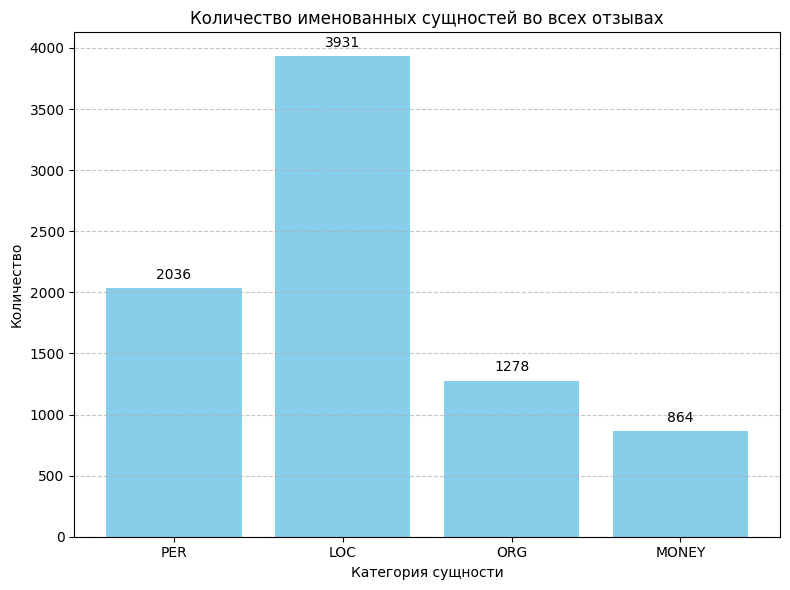

In [161]:
df = pd.DataFrame(text_ent_count.items(), columns=['Entity', 'Count'])

plt.figure(figsize=(8, 6))
bars = plt.bar(df['Entity'], df['Count'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

plt.title('Количество именованных сущностей во всех отзывах')
plt.xlabel('Категория сущности')
plt.ylabel('Количество')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Чаще всего в отзывах люди упоминают места, которые посетили (скорее всего, город), а не сам объект (организаций втрое меньше). Интересно, что людей упоминают достаточно часто, в каждом пятом отзыве. Возможно, речь о сотрудниках или, что более вероятно, об исторических личностях

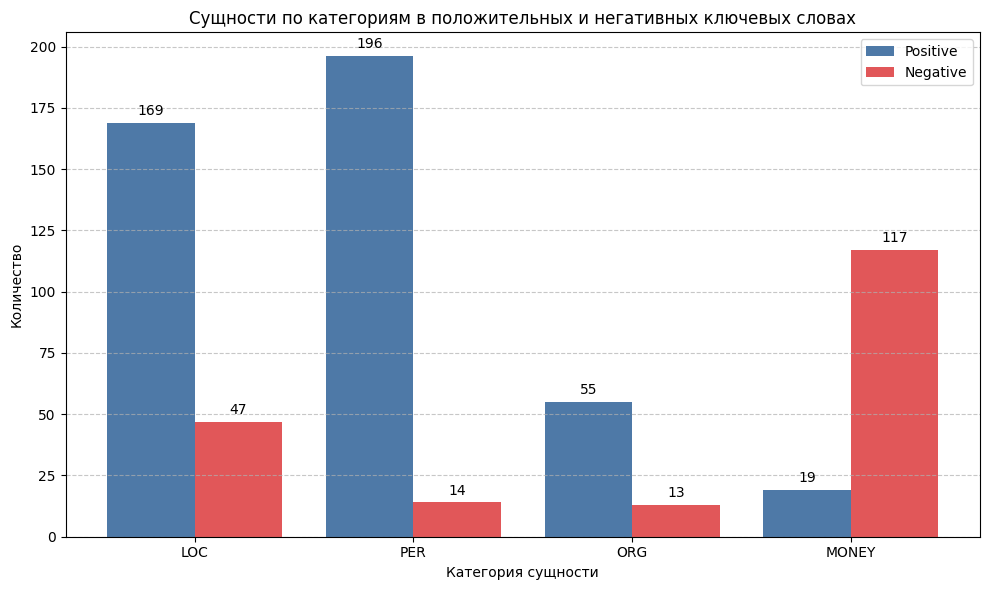

In [162]:
categories = ['LOC', 'PER', 'ORG', 'MONEY']

pos_values = [positive_ent_count[cat] for cat in categories]
neg_values = [negative_ent_count[cat] for cat in categories]

bar_width = 0.4
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, pos_values, bar_width, label='Positive', color='#4E79A7')
bar2 = ax.bar(index + bar_width, neg_values, bar_width, label='Negative', color='#E15759')

ax.set_xlabel('Категория сущности')
ax.set_ylabel('Количество')
ax.set_title('Сущности по категориям в положительных и негативных ключевых словах')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 2,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Интересно! Выходит, что для позитивных отзывов характерно частое упоминание **места** и **людей** (например, имен сотрудников, которых они хотели бы похвалить, или же исторических деятелей). Для негативных отзывов, напротив, часто встает вопрос **денежный** (слишком высокая цена за билет), остальные категории встречаются значительно реже

## А теперь лемматизируем сущности и визуализируем в виде облака слов

In [134]:
def lemmatize_ents(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    lemmas = []
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        lm = token.lemma.lower()
        if len(lm) > 2 and lm not in stop_words:
            lemmas.append(lm)
    
    return lemmas

In [ ]:
text_ents = ' '.join([ent.split(' -> ')[0] for ents in df_analysis['text_ents'] for ent in ents])
lemmatized_text_ents = lemmatize_ents(text_ents)

pos_ents = ' '.join([ent.split(' -> ')[0] for ents in df_analysis['positive_ents'] for ent in ents])
lemmatized_pos_ents = lemmatize_ents(pos_ents)

neg_ents = ' '.join([ent.split(' -> ')[0] for ents in df_analysis['negative_ents'] for ent in ents])
lemmatized_neg_ents = lemmatize_ents(neg_ents)

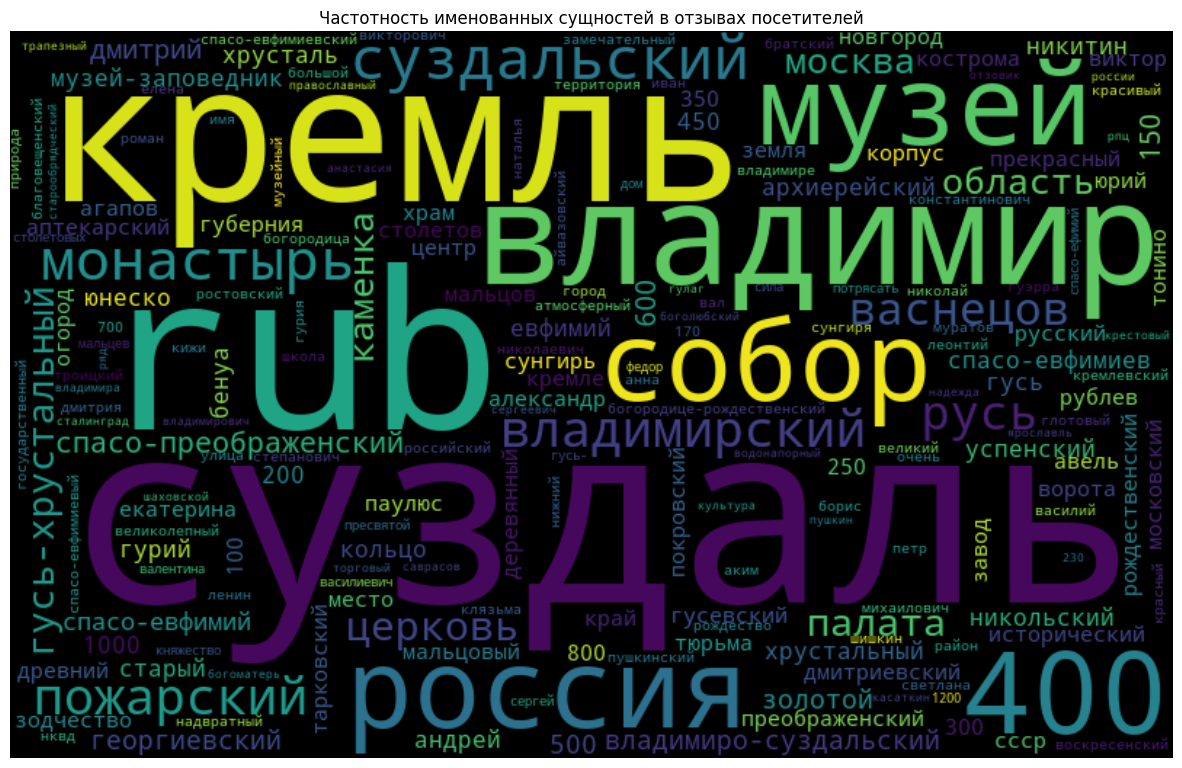

In [136]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(Counter(lemmatized_text_ents))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность именованных сущностей в отзывах посетителей')
plt.show()

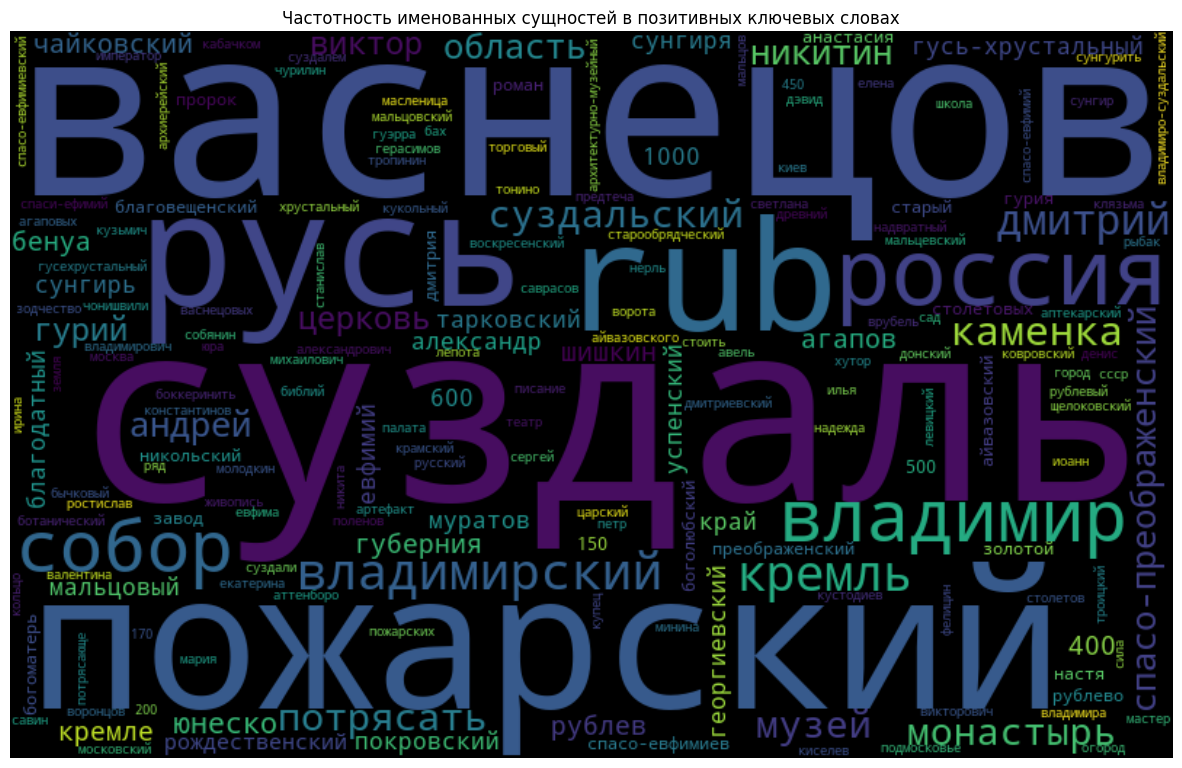

In [137]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(Counter(lemmatized_pos_ents))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность именованных сущностей в позитивных ключевых словах')
plt.show()

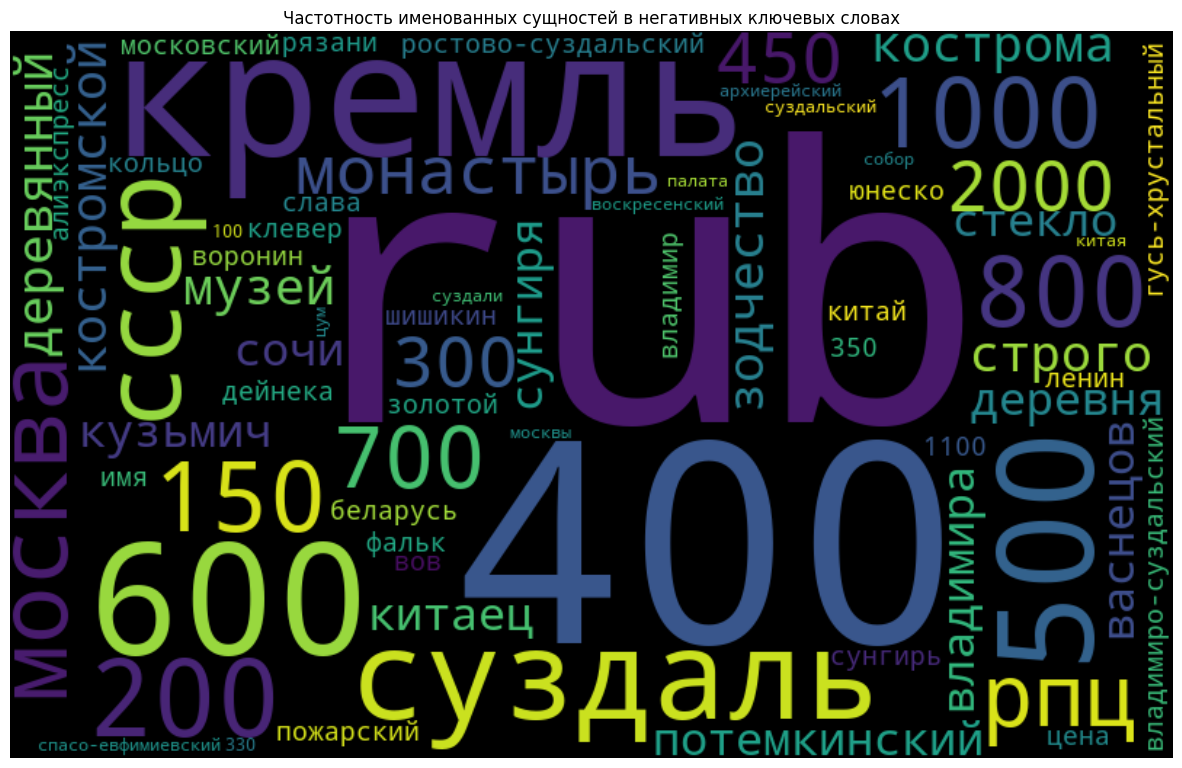

In [138]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(Counter(lemmatized_neg_ents))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность именованных сущностей в негативных ключевых словах')
plt.show()

### Преобладание того или иного объекта скорее всего связано с количеством отзывов на него, ведь выборка крайне несбалансирована. Но мы все равно можем увидеть некоторые тенденции, которые заметны и на частотном анализе категорий сущностей - у негативных отзывов все в рублях и цифрах, у позитивных - в исторических деятелях

## Стало интересно взглянуть на все __леммы__ в ключевых словах, не только именованные сущности

In [143]:
positive_words_freqs = Counter(lemmatize_ents(' '.join(review for review in df_analysis['positives'])))
negative_words_freqs = Counter(lemmatize_ents(' '.join(review for review in df_analysis['negatives'])))

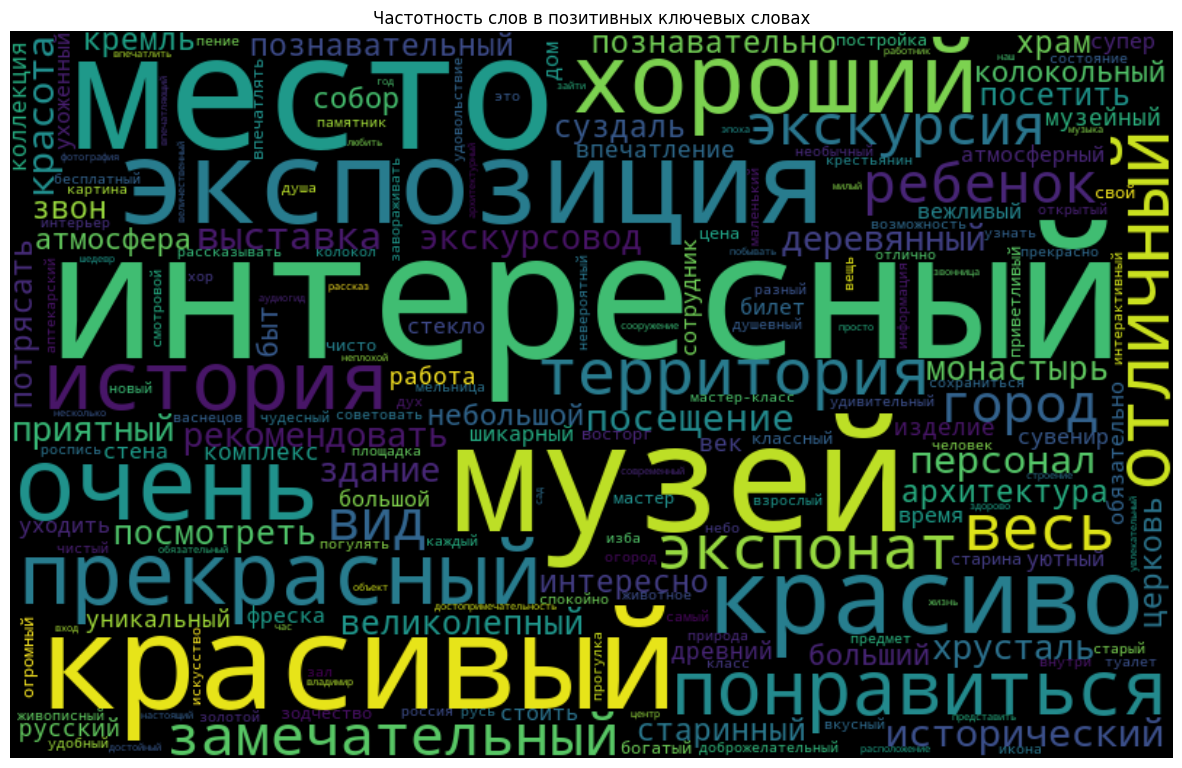

In [144]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(positive_words_freqs)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность слов в позитивных ключевых словах')
plt.show()

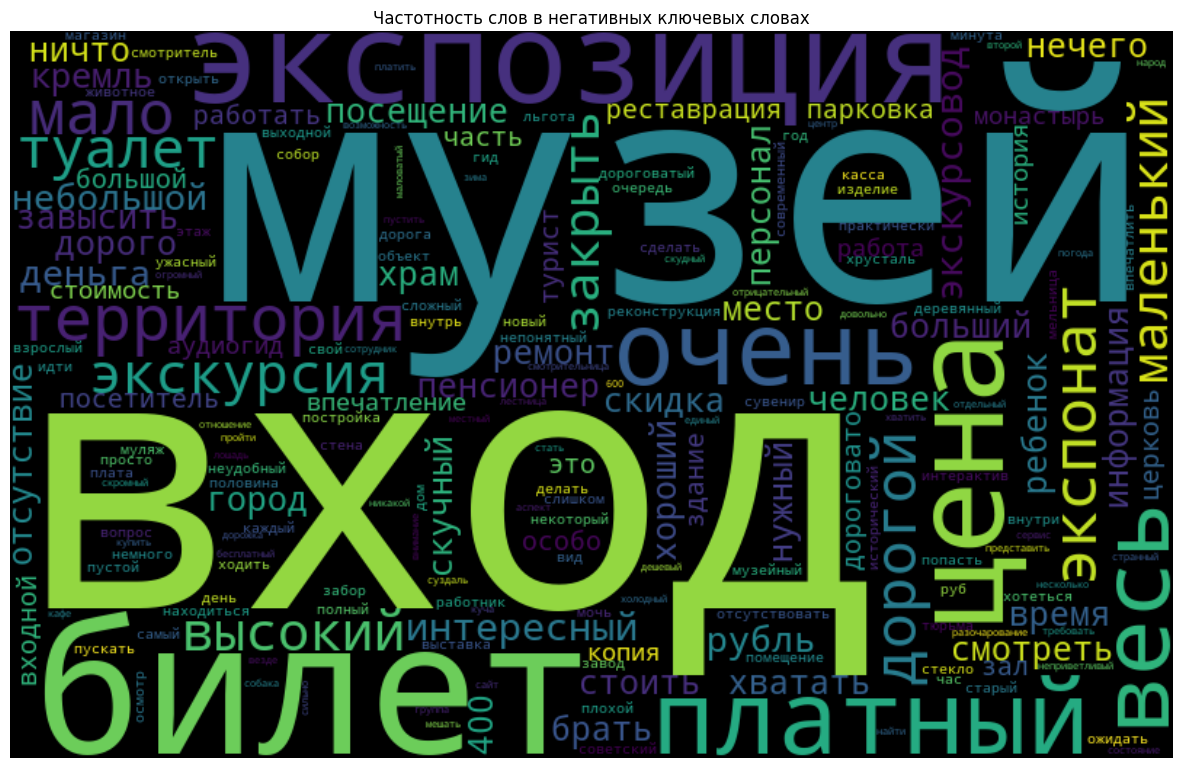

In [145]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(negative_words_freqs)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность слов в негативных ключевых словах')
plt.show()

### Многое совпадает. Конечно, очень частотны очевидные слова __экспозиция__ и __музей__. Но можно отметить в позитивных преобладание __интересный__, а в негативных - __вход__, __билет__, __платный__ (даже уже немного наскучило говорить про деньги, но таковы отзывы). Возможно, будет нагляднее сравнить самые частые слова в двух тональностях на графиках

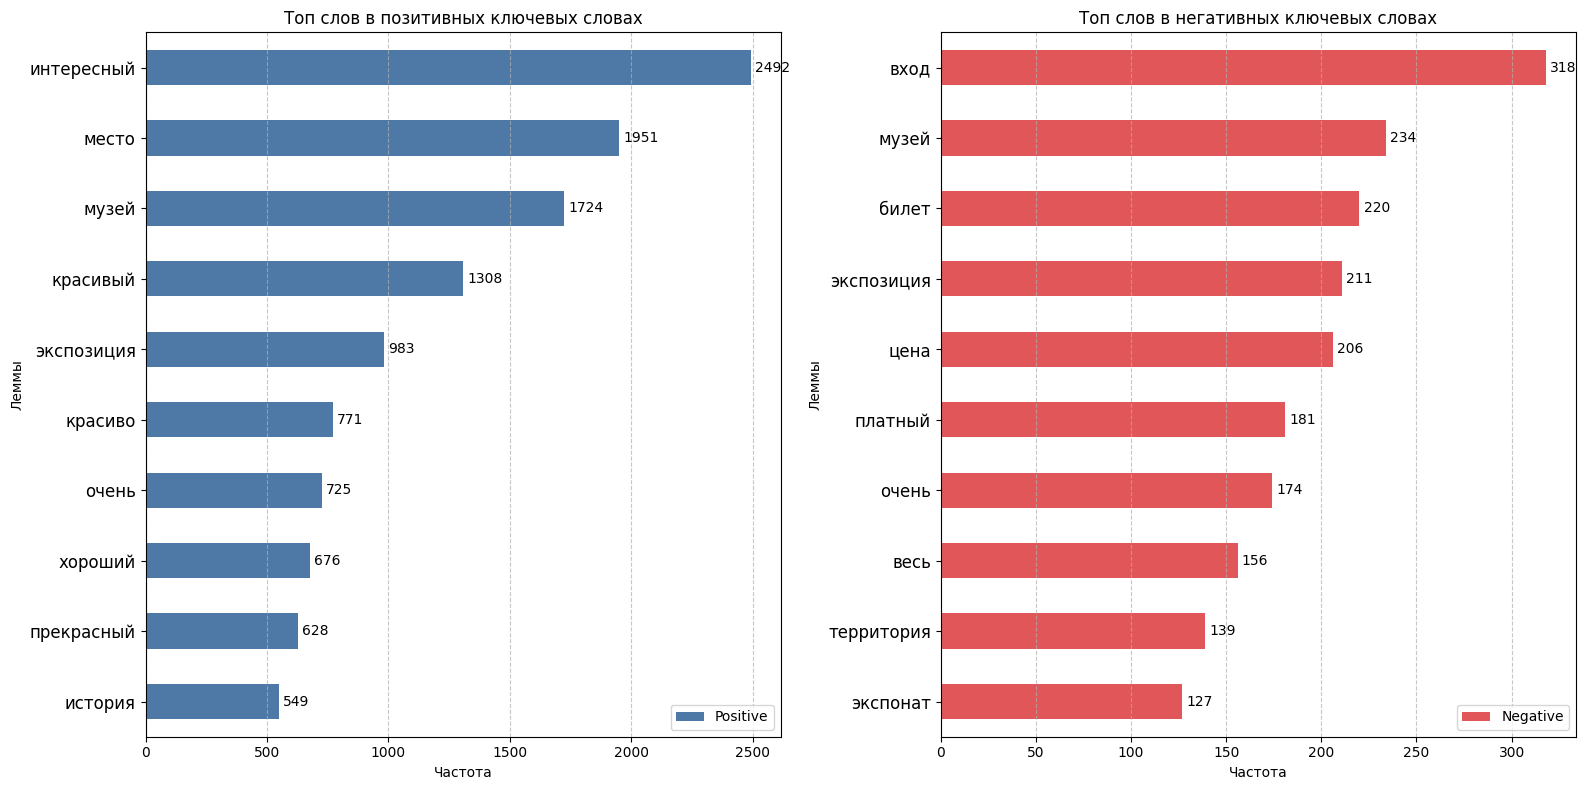

In [165]:
top_n = 10

top_positive = dict(positive_words_freqs.most_common(top_n))
top_negative = dict(negative_words_freqs.most_common(top_n))

df_pos = pd.DataFrame({'Lemma': list(top_positive.keys()), 
                      'Positive': list(top_positive.values())})
df_neg = pd.DataFrame({'Lemma': list(top_negative.keys()), 
                      'Negative': list(top_negative.values())})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

df_pos.plot(kind='barh', ax=ax1, color='#4E79A7')
ax1.set_title('Топ слов в позитивных ключевых словах')
ax1.set_xlabel('Частота')
ax1.set_ylabel('Леммы')
ax1.set_yticks(range(len(df_pos)))  
ax1.set_yticklabels(df_pos['Lemma'], fontsize=12)  
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

df_neg.plot(kind='barh', ax=ax2, color='#E15759')
ax2.set_title('Топ слов в негативных ключевых словах')
ax2.set_xlabel('Частота')
ax2.set_ylabel('Леммы')
ax2.set_yticks(range(len(df_neg)))  
ax2.set_yticklabels(df_neg['Lemma'], fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)

for container in ax1.containers:
    ax1.bar_label(container, label_type='edge', padding=3)
for container in ax2.containers:
    ax2.bar_label(container, label_type='edge', padding=3)

plt.tight_layout()
plt.show()



## Итак, перед нами интересная картина
* В __позитивных__ ключевых словах очень много оценочной лексики (обилие прилагательных с позитивной субъективной окраской) и собственно объектов, которые они описывают
* В __негативных__ ключевых словах больше конкретики, которая в основном связана со стоимостью входа, а также с качеством объектов 

## А может, нам стоит посмотреть частеречную разметку?

In [151]:
def tag_pos(text):
    doc = Doc(' '.join(text))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    return [token.pos for token in doc.tokens]

In [152]:
positive_pos = Counter(tag_pos(lemmatize_ents(' '.join(review for review in df_analysis['positives']))))
negative_pos = Counter(tag_pos(lemmatize_ents(' '.join(review for review in df_analysis['negatives']))))

In [159]:
total_positive_pos = sum([freq for freq in positive_pos.values()])
total_negative_pos = sum([freq for freq in negative_pos.values()])

def normalize_pos_frequencies(freqs, total_tokens):
    return {pos: freq / total_tokens * 100 for pos, freq in freqs.items()}

positive_pos_norm = normalize_pos_frequencies(positive_pos, total_positive_pos)
negative_pos_norm = normalize_pos_frequencies(negative_pos, total_negative_pos)

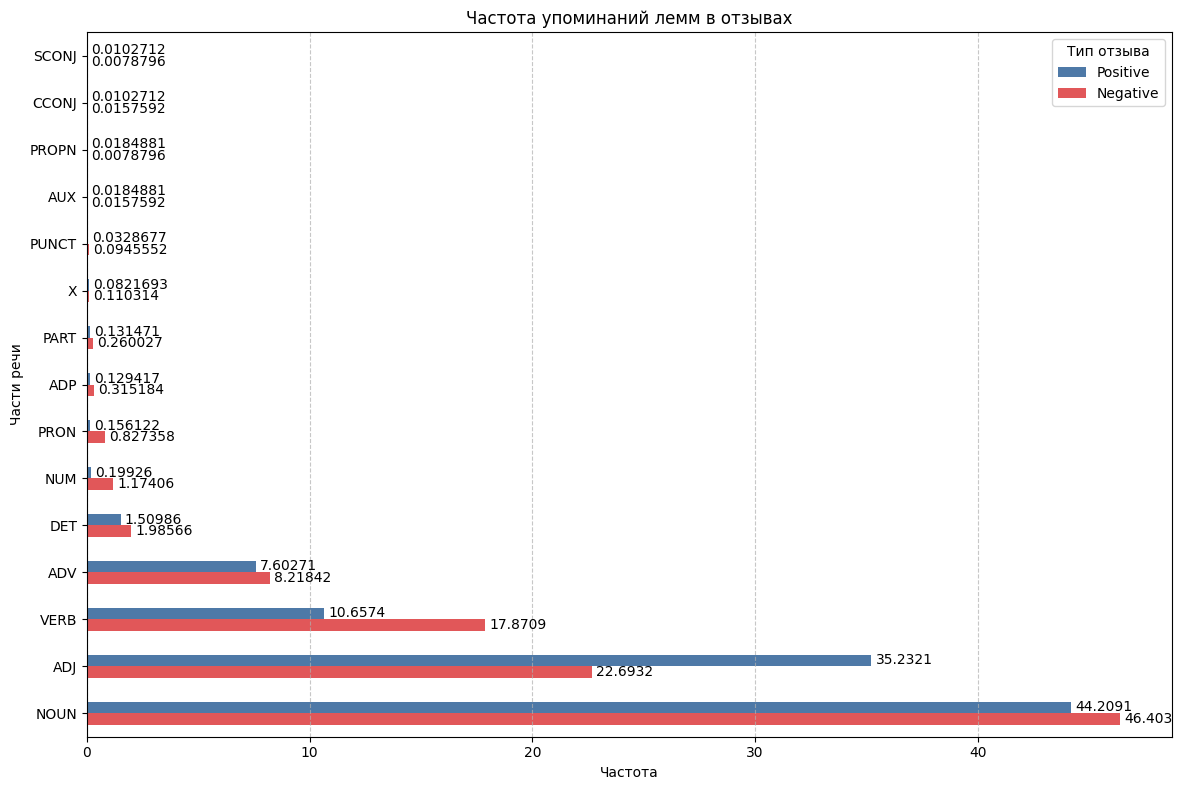

In [160]:
df_pos = pd.DataFrame({'POS': list(positive_pos_norm.keys()), 'Positive': list(positive_pos_norm.values())})
df_neg = pd.DataFrame({'POS': list(negative_pos_norm.keys()), 'Negative': list(negative_pos_norm.values())})

df = pd.merge(df_pos, df_neg, on='POS', how='outer').fillna(0).set_index('POS')

df['Total'] = df['Positive'] + df['Negative']
df_sorted = df.sort_values(by='Total', ascending=True).drop(columns='Total')

fig, ax = plt.subplots(figsize=(12, 8))
df_sorted.plot(kind='barh', ax=ax, color=['#4E79A7', '#E15759'])

ax.set_title('Частота частей речи в отзывах')
ax.set_xlabel('Частота')
ax.set_ylabel('Части речи')
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.legend(title='Тип отзыва')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.tight_layout()
plt.show()

## Несколько выводов по частям речи в ключевых словах
* Существительные преобладают во всех отзывах (почти половина всех слов)
* В позитивных отзывах значительно чаще встречаются прилагательные (может быть связано с высокой частотностью слова *интересно*)
* В негативных отзывах значительно больше глаголов (часто в отзывах отмечают, что объект ***закрыт** на реконструкцию* или *билет **стоит** дорого*)
* В негативных отзывах также намного больше числительных, что уже неудивительно